# Data analysis and statistics to the full Datasport dataset

In this notebook we present:

* [Exploratory Statistics](#Exploratory-statistics)

    * [Distribution of runners across time](#Distribution-of-runners-across-time)
    * [Distribution of #editions, per race](#Distribution-of-#editions,-per-race)
    * [Distribution of #runners, per race](#Distribution-of-#runners,-per-race)
    * [Distribution of #races, per runner](#Distribution-of-#races,-per-runner)
    * [Performance VS Age](#Performance-VS-Age)
    * [Performance VS Weather](#Performance-VS-Weather)
    
    
* [Predictive Statistics](#Predictive-Statistics)
    * [Machine Learning-driven analysis](#ML-driven-analysis) on runners' performances 


(remind that the workflow we try to follow in this study is the one suggested in this [useful paper](http://science.sciencemag.org/content/347/6228/1314.full)

---

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import datetime
from scipy import stats

import seaborn as sns
sns.set_context('notebook')
%config InlineBackend.figure_format = 'retina'

## Exploratory statistics

### Loading the dataset

In [2]:
full_df = pd.read_pickle('../../df_userID.pickle')

print(full_df.shape)
print('\n Number of nulls: \n\n', full_df.isnull().sum())
print('\n Data-type: \n\n', full_df.dtypes)
full_df.head(3)

(1648676, 19)

 Number of nulls: 

 Race                0
Date                0
RaceYear            0
RaceMonth           0
Category            0
Distance            0
Name                0
Sex                 0
Year            36620
LivingPlace         0
Rank                0
Time                0
Pace                0
Place               0
MinTemp        546671
MaxTemp        546671
Weather        546671
RaceID              0
UserID              0
dtype: int64

 Data-type: 

 Race                    object
Date                    object
RaceYear                 int64
RaceMonth                int64
Category                object
Distance               float64
Name                    object
Sex                     object
Year                   float64
LivingPlace             object
Rank                     int64
Time           timedelta64[ns]
Pace           timedelta64[ns]
Place                   object
MinTemp                float64
MaxTemp                float64
Weather              

,Race,Date,RaceYear,RaceMonth,Category,Distance,Name,Sex,Year,LivingPlace,Rank,Time,Pace,Place,MinTemp,MaxTemp,Weather,RaceID,UserID
0,Kerzerslauf,sam. 18.03.2000,2000,3,M20,15.0,Abgottspon Peter,M,1974.0,Zermatt,233,01:02:25,00:04:09,Kerzers,NaN,NaN,NaN,http://services.datasport.com/2000/lauf/kerzers,Abgottspon Peter 1974.0
1,Kerzerslauf,sam. 18.03.2000,2000,3,M35,15.0,Abplanalp Michael,M,1964.0,Bern,32,00:55:11.700000,00:03:40,Kerzers,NaN,NaN,NaN,http://services.datasport.com/2000/lauf/kerzers,Abplanalp Michael 1964.0
2,Kerzerslauf,sam. 18.03.2000,2000,3,M50,15.0,Abt Werner,M,1947.0,Spiez,155,01:12:42.900000,00:04:50,Kerzers,NaN,NaN,NaN,http://services.datasport.com/2000/lauf/kerzers,Abt Werner 1947.0


#### Remove useless features

In [3]:
full_df.drop('Date', axis=1, inplace=True)
full_df.drop('Rank', axis=1, inplace=True)
full_df.drop('Category', axis=1, inplace=True)

#### Global tranformation of features

In [4]:
# in order to plot age instead of year of birth
full_df.Year = 2016 - full_df.Year

# Round `Distance` feature:
full_df.Distance = full_df.Distance.round()
full_df.Distance = full_df.Distance.astype('int')
full_df.Distance.unique()

# transform timedelta in minutes!
full_df.Time = full_df.Time.astype('timedelta64[m]')

# transform Pace timedelta in sec!  - here is better to keep lower resolution!
full_df.Pace = full_df.Pace.astype('timedelta64[s]')

# these 2 are actually the same event!
full_df.Race = full_df.Race.apply(
    lambda x: 'Lucerne Marathon, Luzern' if x == 'SwissCityMarathon - Lucerne, Luzern' else x
)

### Distribution of runners across time
(mind that data are binned by year - each runner might _compete several times_ in the same year)

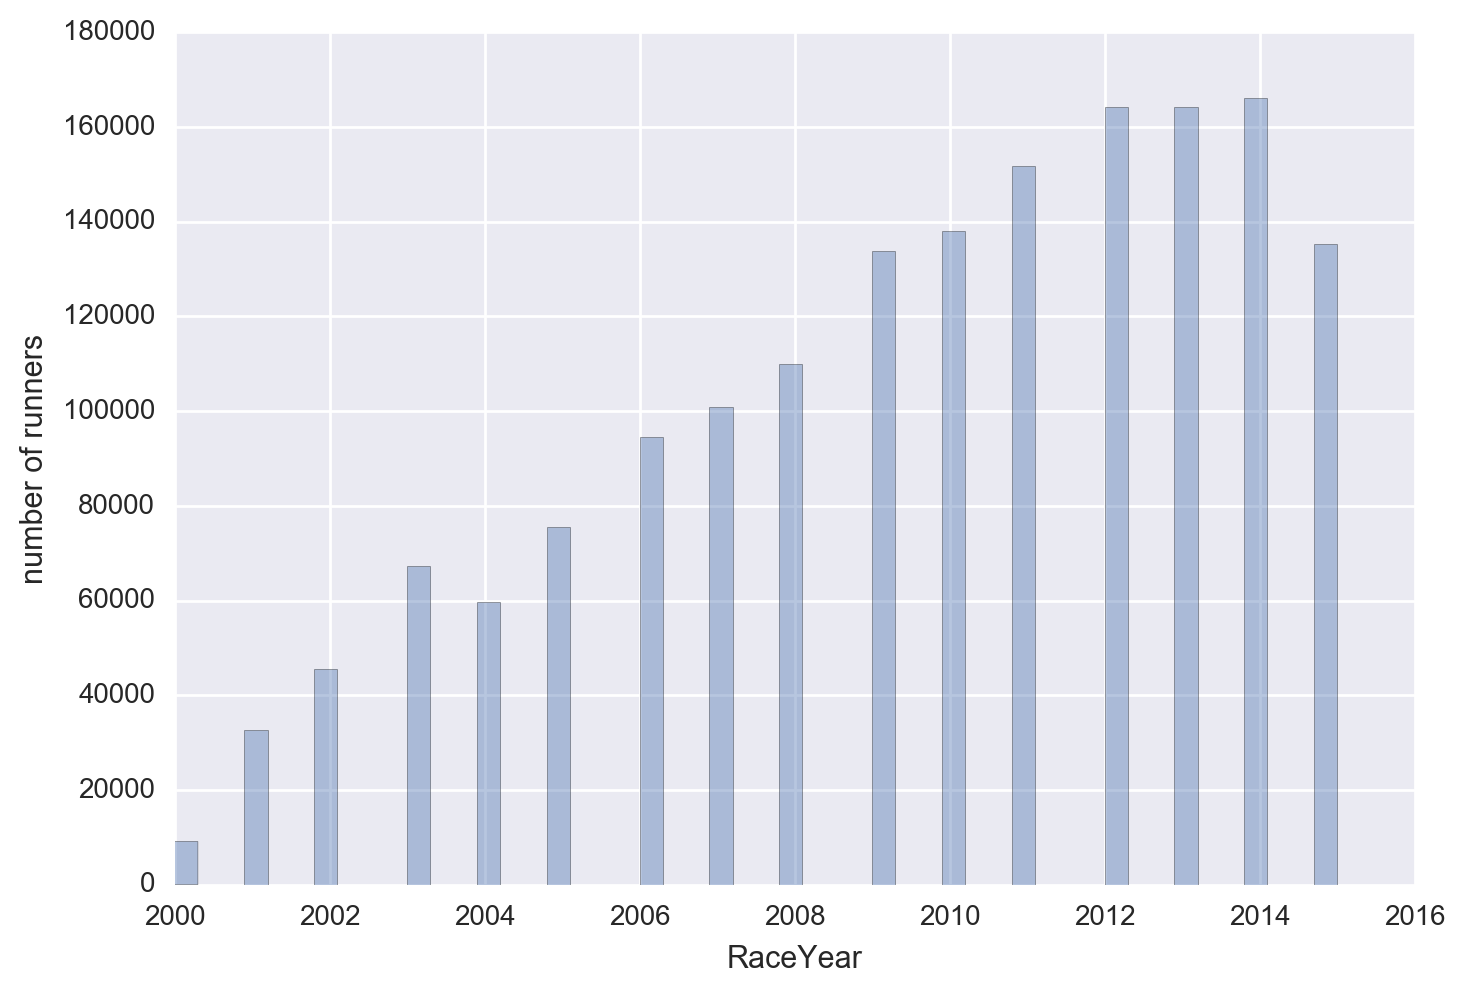

In [5]:
sns.distplot(full_df.RaceYear,kde=False)
plt.ylabel('number of runners');

It might be also intersting to see, in which month _along the year_, most of the events happened:

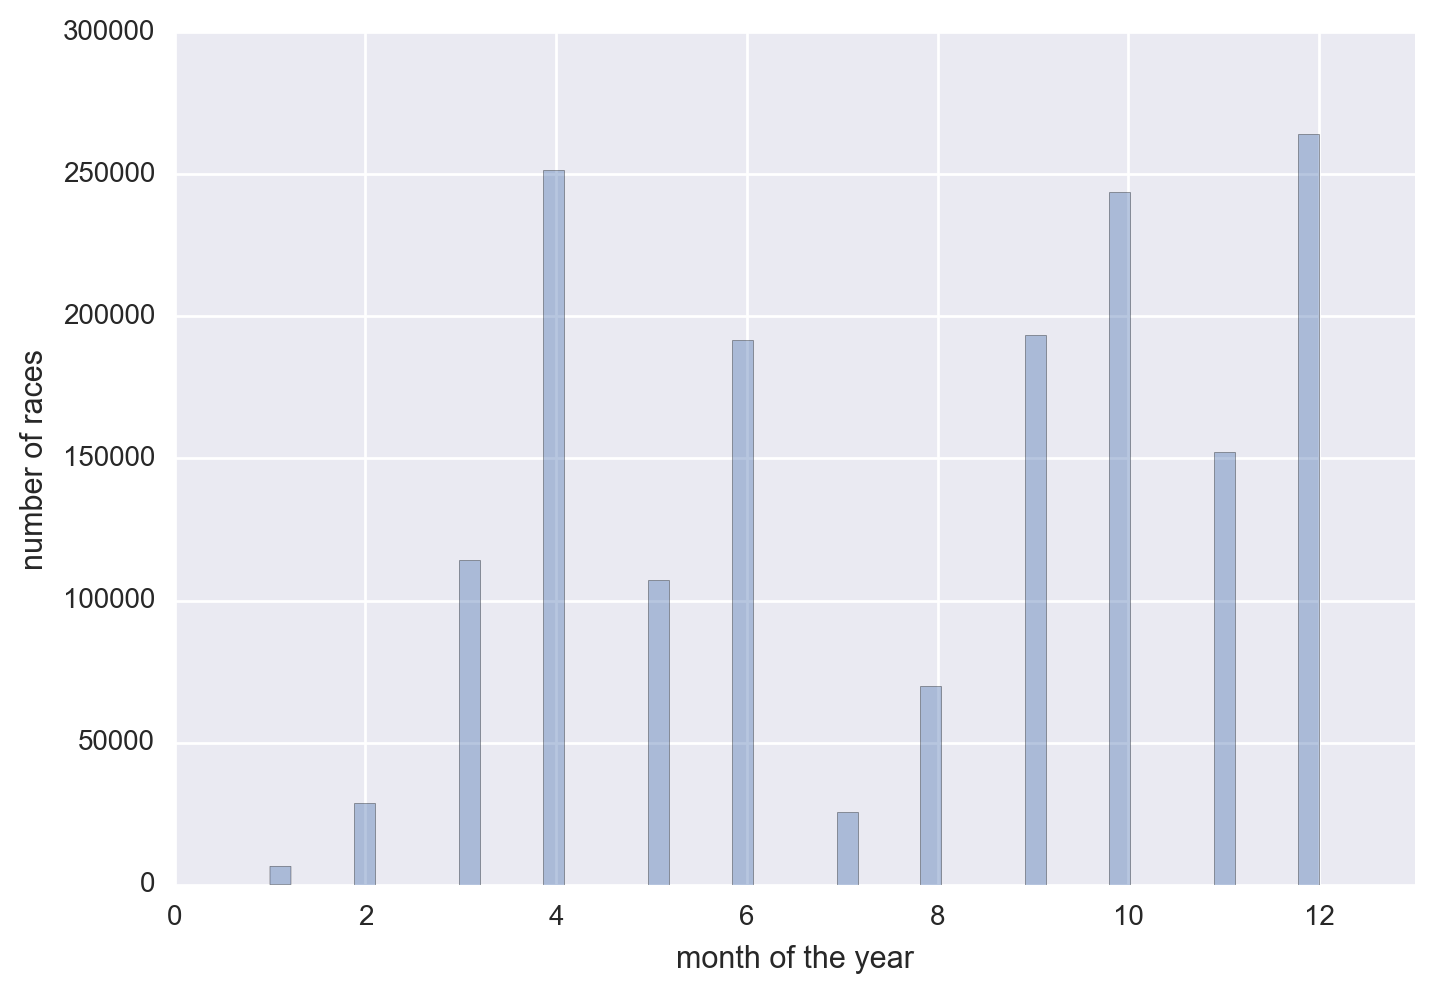

In [6]:
sns.distplot(full_df.RaceMonth,kde=False)
plt.xlabel('month of the year')
plt.xlim([0,13])
plt.ylabel('number of races');

### Distribution of #editions, per race

In [7]:
print('Number of unique races:',full_df.Race.nunique())

Number of unique races: 222


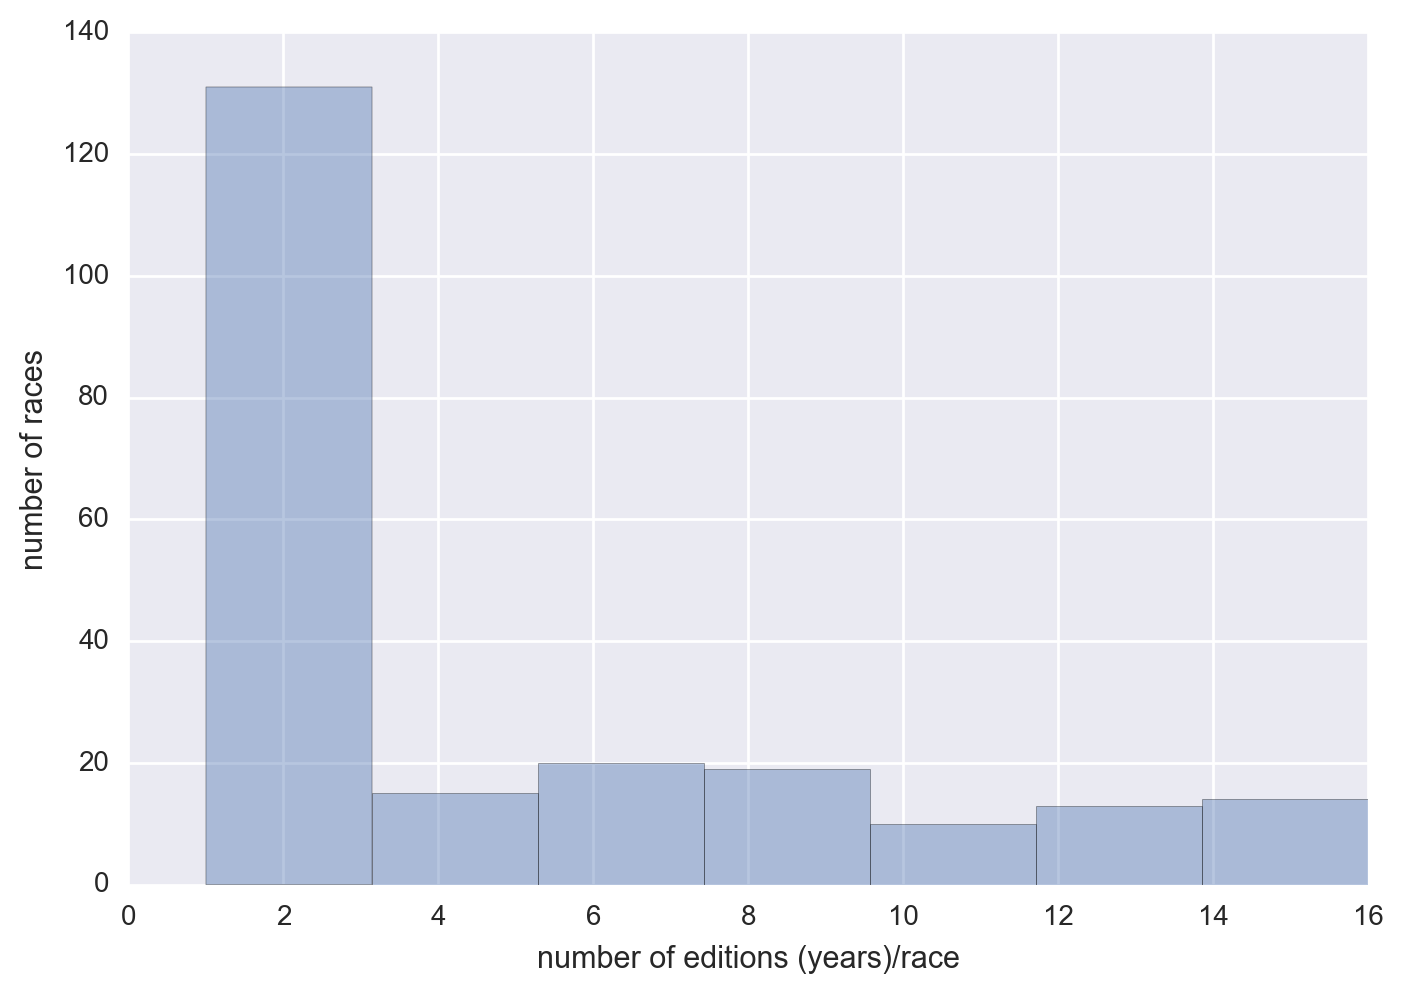

In [8]:
race_edi_count = full_df.groupby('Race').RaceYear.nunique()

sns.distplot(race_edi_count.values,kde=False)
plt.xlabel('number of editions (years)/race')
plt.ylabel('number of races');

These are the first 20 __most frequent races__ in the history:

In [9]:
sorted_race_edi_count = sorted(race_edi_count.items(),key=lambda x:x[1],reverse=True)[:20]
sorted_race_edi_count

[('Chäsitzerlouf, Kehrsatz', 16),
 ('20km de Lausanne', 15),
 ('Basler Stadtlauf', 15),
 ('Frauenfelder', 15),
 ('Gurtenclassic, Wabern', 15),
 ('Kerzerslauf', 15),
 ('Schweizer Frauenlauf Bern', 15),
 ('Badener Limmat-Lauf, Baden', 14),
 ('Dietiker Neujahrslauf, Dietikon', 14),
 ('GP Fricktal, Eiken', 14),
 ('Hallwilerseelauf, Beinwil am See', 14),
 ('Kyburglauf, Kyburg', 14),
 ('Langenthaler Stadtlauf', 14),
 ('Pfingstlauf Wohlen AG', 14),
 ('ASICS Bremgarter Reusslauf', 13),
 ("Course de l'Escalade, Genève", 13),
 ('Hellebardenlauf Sempach', 13),
 ('Steinhölzlilauf, Liebefeld', 13),
 ('Thuner Stadtlauf, Thun', 13),
 ('Walliseller Lauf, Wallisellen', 13)]

### Distribution of #runners, per race  
(how popular is a race?)

In [15]:
# note that the UserID is still not 'perfect' 
print('(under) estimation of number of runners:',full_df.UserID.nunique())

(under) estimation of number of runners: 531426


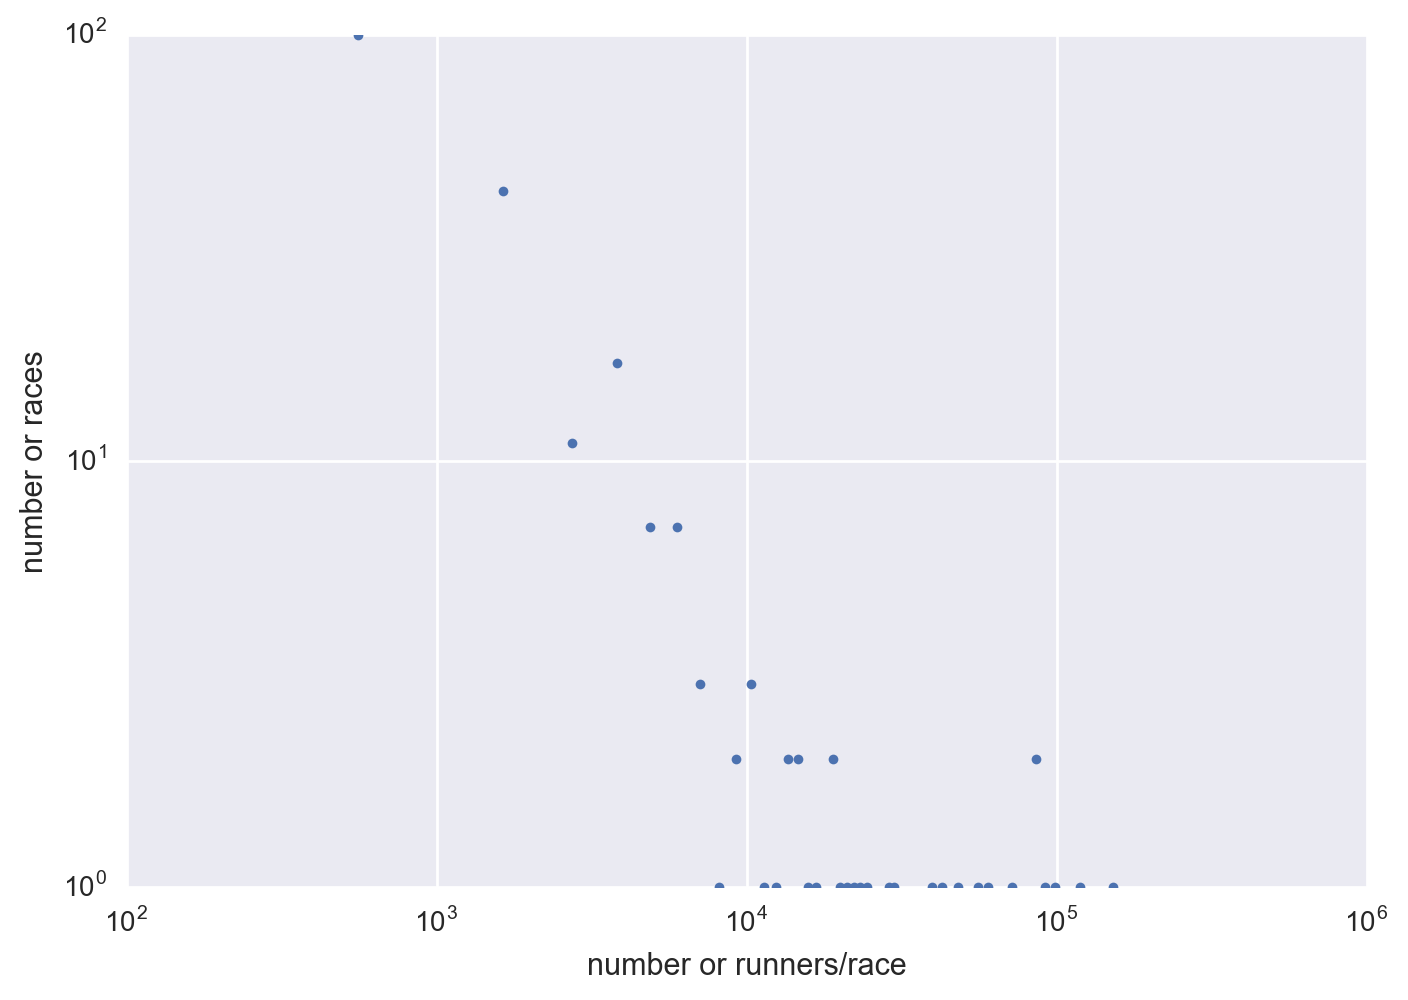

In [16]:
my_hist, bin_edges = np.histogram(full_df.Race.value_counts(),bins='fd')
bin_centers = (bin_edges[1:] + bin_edges[:-1])/2

plt.loglog(bin_centers,my_hist,marker='.',linestyle='')

plt.ylabel('number or races')
plt.xlabel('number or runners/race');

### Distribution of #races, per runner
(how active is a runner?)

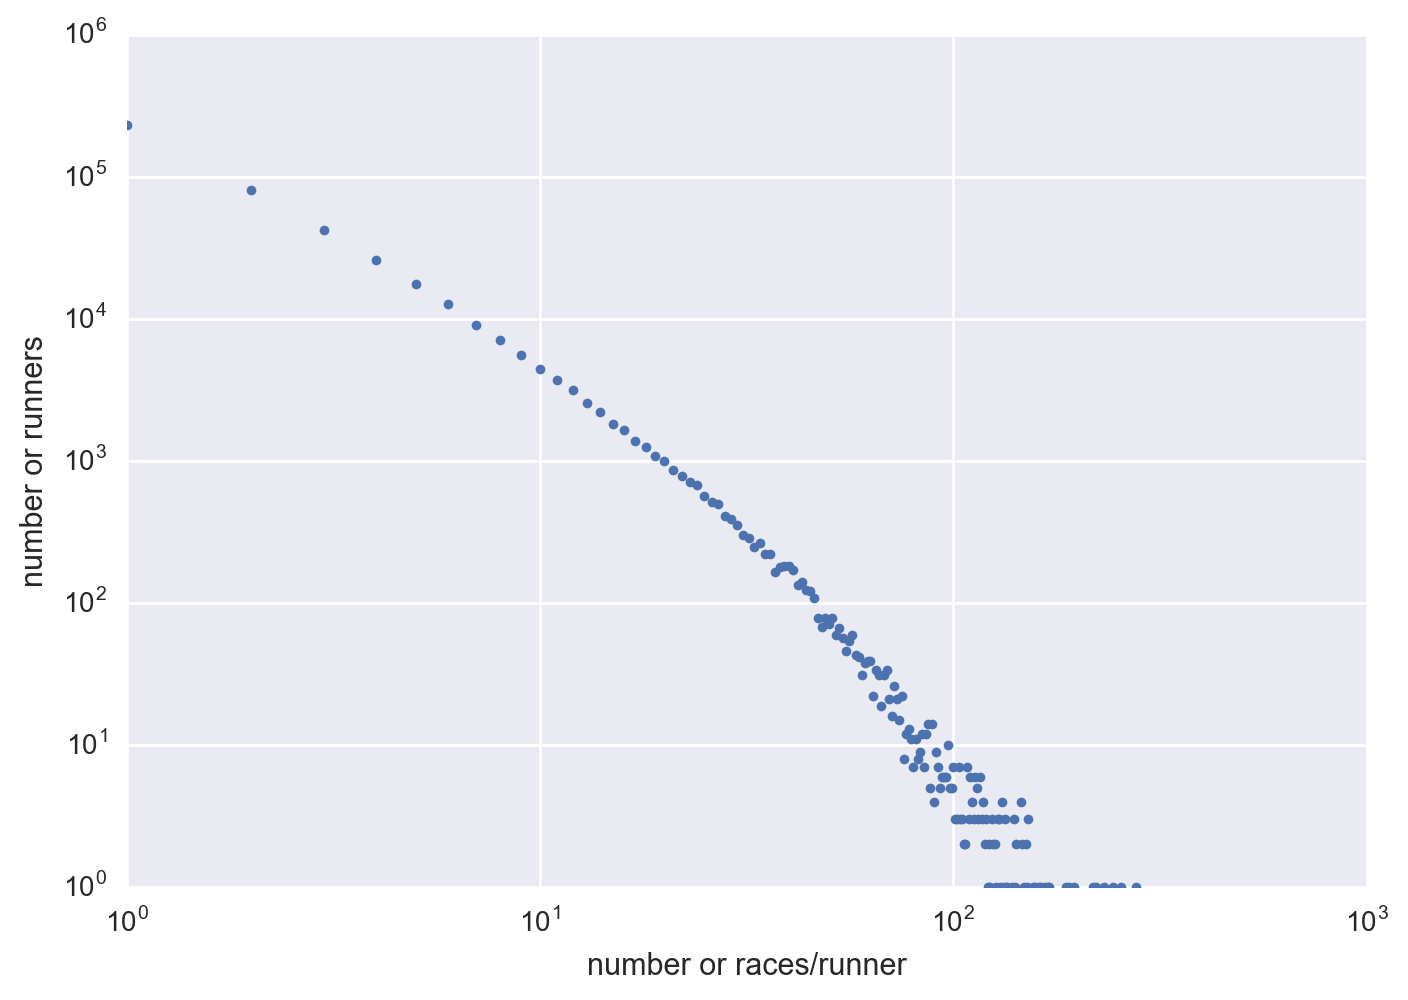

In [17]:
plt.loglog(full_df.Name.value_counts().value_counts(),marker='.',linestyle='')
plt.ylabel('number or runners')
plt.xlabel('number or races/runner');

### Performance VS Age  

This question has been already investigated in recent studies, on different races across the world. Here are few examples, from 
[2014(1)](http://bmcsportsscimedrehabil.biomedcentral.com/articles/10.1186/2052-1847-6-31),
[2014(2)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4039284/),
[2015](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4541133/),
[2016](http://www.sciencedirect.com/science/article/pii/S2095254615000435).

All of them found a _U-shaped dependence_, for both males and females

Let's consider for simplicity the races with largest number of runners (across all editions):

In [10]:
full_df.Race.value_counts().sort_values(ascending=False)[:20]

Course de l'Escalade, Genève            152815
Schweizer Frauenlauf Bern               118906
20km de Lausanne                         98783
Morat-Fribourg                           91950
Kerzerslauf                              86246
Zürcher Silvesterlauf, Zürich            86113
Int Greifenseelauf, Uster                71820
Zürich Marathon, Teamrun und Cityrun     60660
Basler Stadtlauf                         55896
Lucerne Marathon, Luzern                 54393
Hallwilerseelauf, Beinwil am See         48263
Jungfrau-Marathon, Interlaken            42470
Lausanne Marathon                        39957
ASICS Bremgarter Reusslauf               28377
Corrida Bulloise, Bulle                  22891
Luzerner Stadtlauf                       22652
Stralugano, Lugano                       21546
Winterthur Marathon                      20538
Frauenfelder                             19400
Thuner Stadtlauf, Thun                   18739
Name: Race, dtype: int64

#### Check races distances for each event  
We consider _only races with standard running distances_ - like, 10Km, 20Km, 1/2 marathon and marathon.  
Here are some examples:

In [19]:
full_df[full_df.Race=='20km de Lausanne'].Distance.unique()

array([ 20.,  18.,   4.,  10.,   2.])

In [163]:
full_df[full_df.Race=='Basler Stadtlauf'].Distance.unique()

array([  2.,  10.,   6.,   1.,   8.,   3.])

In [162]:
full_df[full_df.Race=='Int Greifenseelauf, Uster'].Distance.unique()

array([ 21.,   1.,   6.,   3.,  10.,   2.])

In [20]:
full_df[full_df.Race=='Schweizer Frauenlauf Bern'].Distance.unique()

array([  5.,  10.])

In [21]:
full_df[full_df.Race=='Zürich Marathon, Teamrun und Cityrun'].Distance.unique()

array([ 42.,  10.])

In [22]:
full_df[full_df.Race=='Lucerne Marathon, Luzern'].Distance.unique()

array([ 42.,  21.,   8.])

In [23]:
full_df[full_df.Race=='SwissCityMarathon - Lucerne, Luzern'].Distance.unique()

array([ 21.,   9.,  42.])

In [24]:
full_df[full_df.Race=='Winterthur Marathon'].Distance.unique()

array([ 21.,  42.,  10.,   1.,   5.])

In [25]:
full_df[full_df.Race=='Lausanne Marathon'].Distance.unique()

array([ 10.,  21.,  42.,   4.,   3.,   1.,   2.])

#### Subsetting data

In [11]:
many_runners_races = full_df.Race.isin([
    'Lausanne Marathon', 'Winterthur Marathon',
    'Zürich Marathon, Teamrun und Cityrun', 'Lucerne Marathon, Luzern',
    'SwissCityMarathon - Lucerne, Luzern', '20km de Lausanne',
    'Schweizer Frauenlauf Bern', 'Int Greifenseelauf, Uster',
    'Basler Stadtlauf'
])

copy_for_U = full_df[many_runners_races].copy()

#  drop Yean NaN and convert them to INT!
copy_for_U = copy_for_U[copy_for_U.Year.notnull()]
copy_for_U.Year = copy_for_U.Year.astype('int')

#### Plot       data for marathon

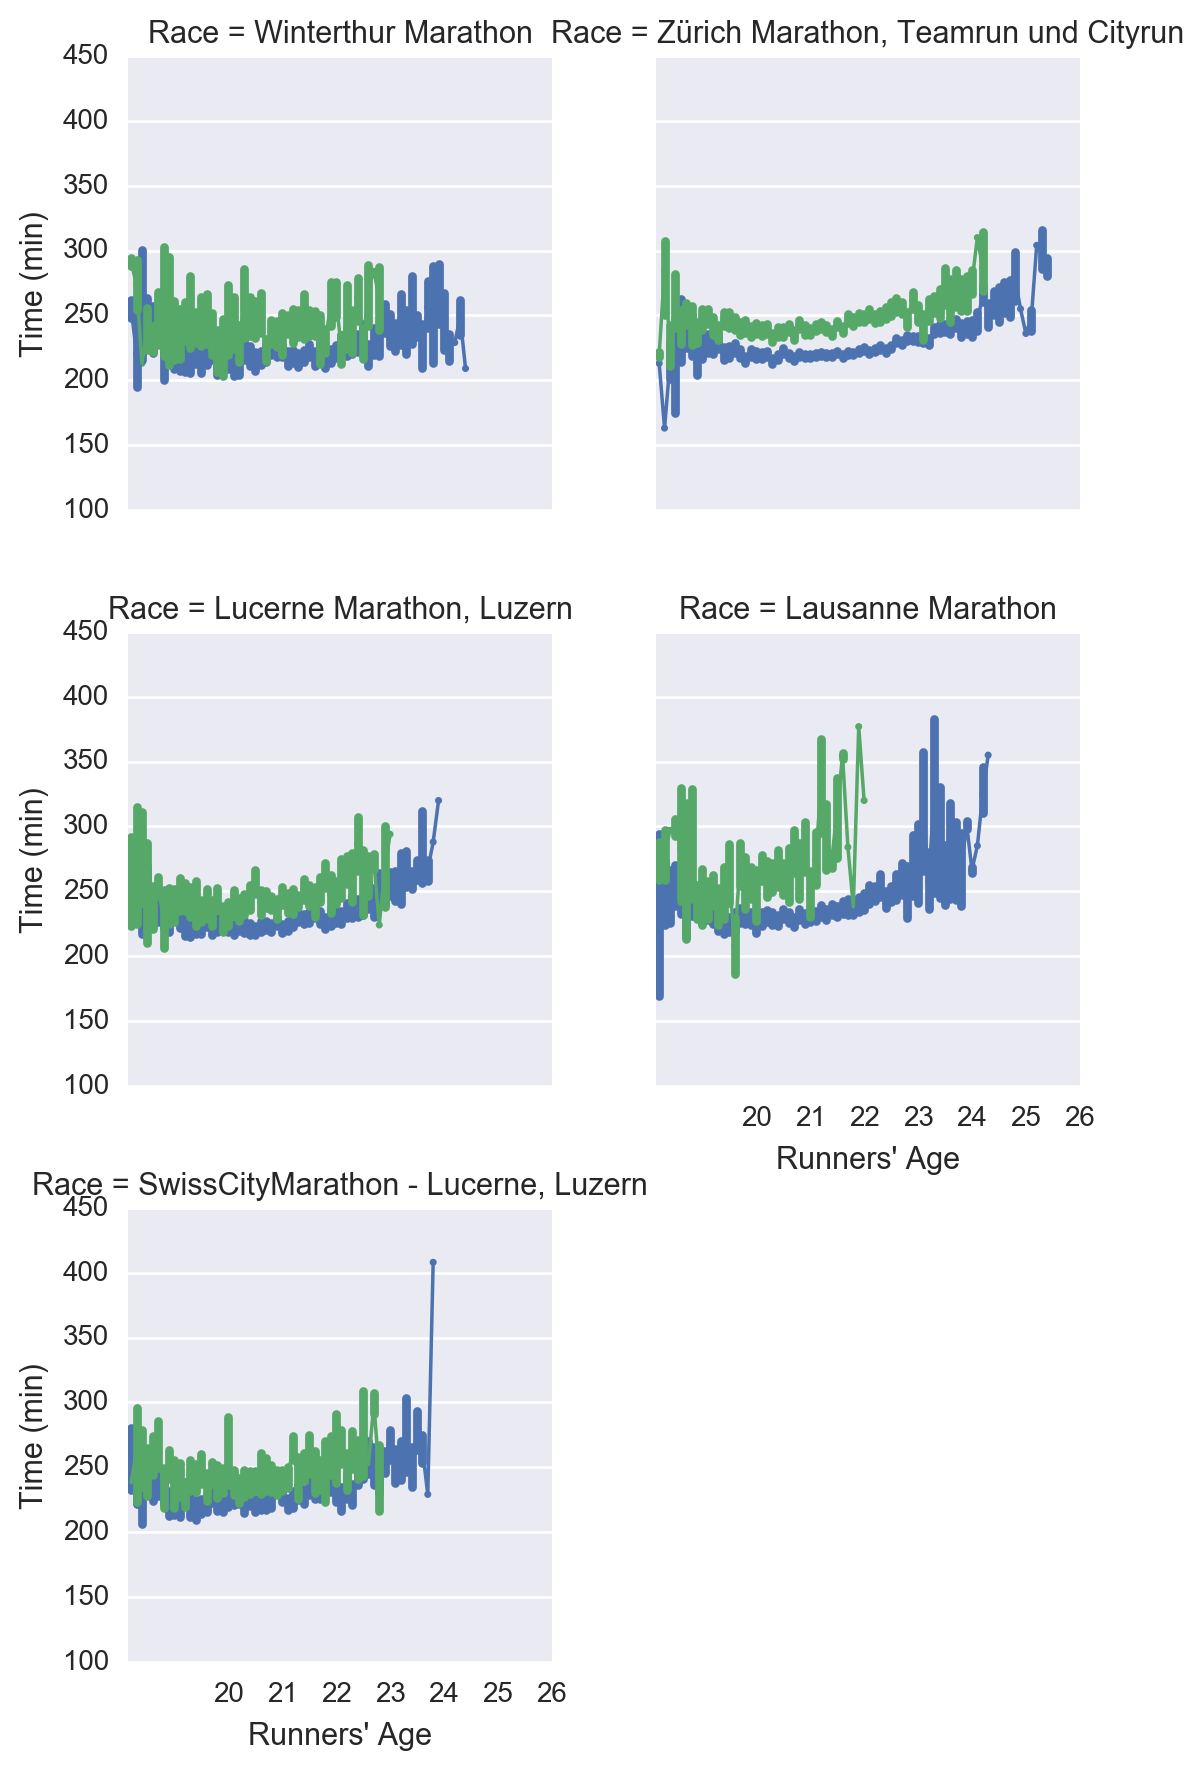

In [95]:
# g = sns.factorplot(data=copy_for_U[copy_for_U.Distance == 42],
#                    x='Year',y='Time',
#                    hue='Sex',col='Race',
#                    scale=0.4,markers='.',
#                    col_wrap=2);

g = sns.FacetGrid(data=copy_for_U[copy_for_U.Distance == 42],
                  hue='Sex',col='Race',col_wrap=2)

g = (g.map(sns.pointplot,'Year','Time',scale=0.4,markers='.')
     .set(xticks=np.arange(18,85,10)));

# g.set_xticklabels(np.arange(18,85,10),rotation=90)
g.set_ylabels('Time (min)');
g.set_xlabels('Runners\' Age');

# sns.FacetGrid.set(xticks=np.arange(18,85,10))

# g = sns.pointplot(data=copy_for_U[marathon_distance &
#                                   (copy_for_U.Race=='Lausanne Marathon')],
#                   x='Year',y='Time',hue='Sex',
#                   scale=0.5)
# plt.xticks(rotation=90);
# g.xaxis.set_ticks(np.arange(18,85,10));

# [1910,1930,1950,1970,1990,2010]

#### Plot   data for  20 Km | 1/2 marathon

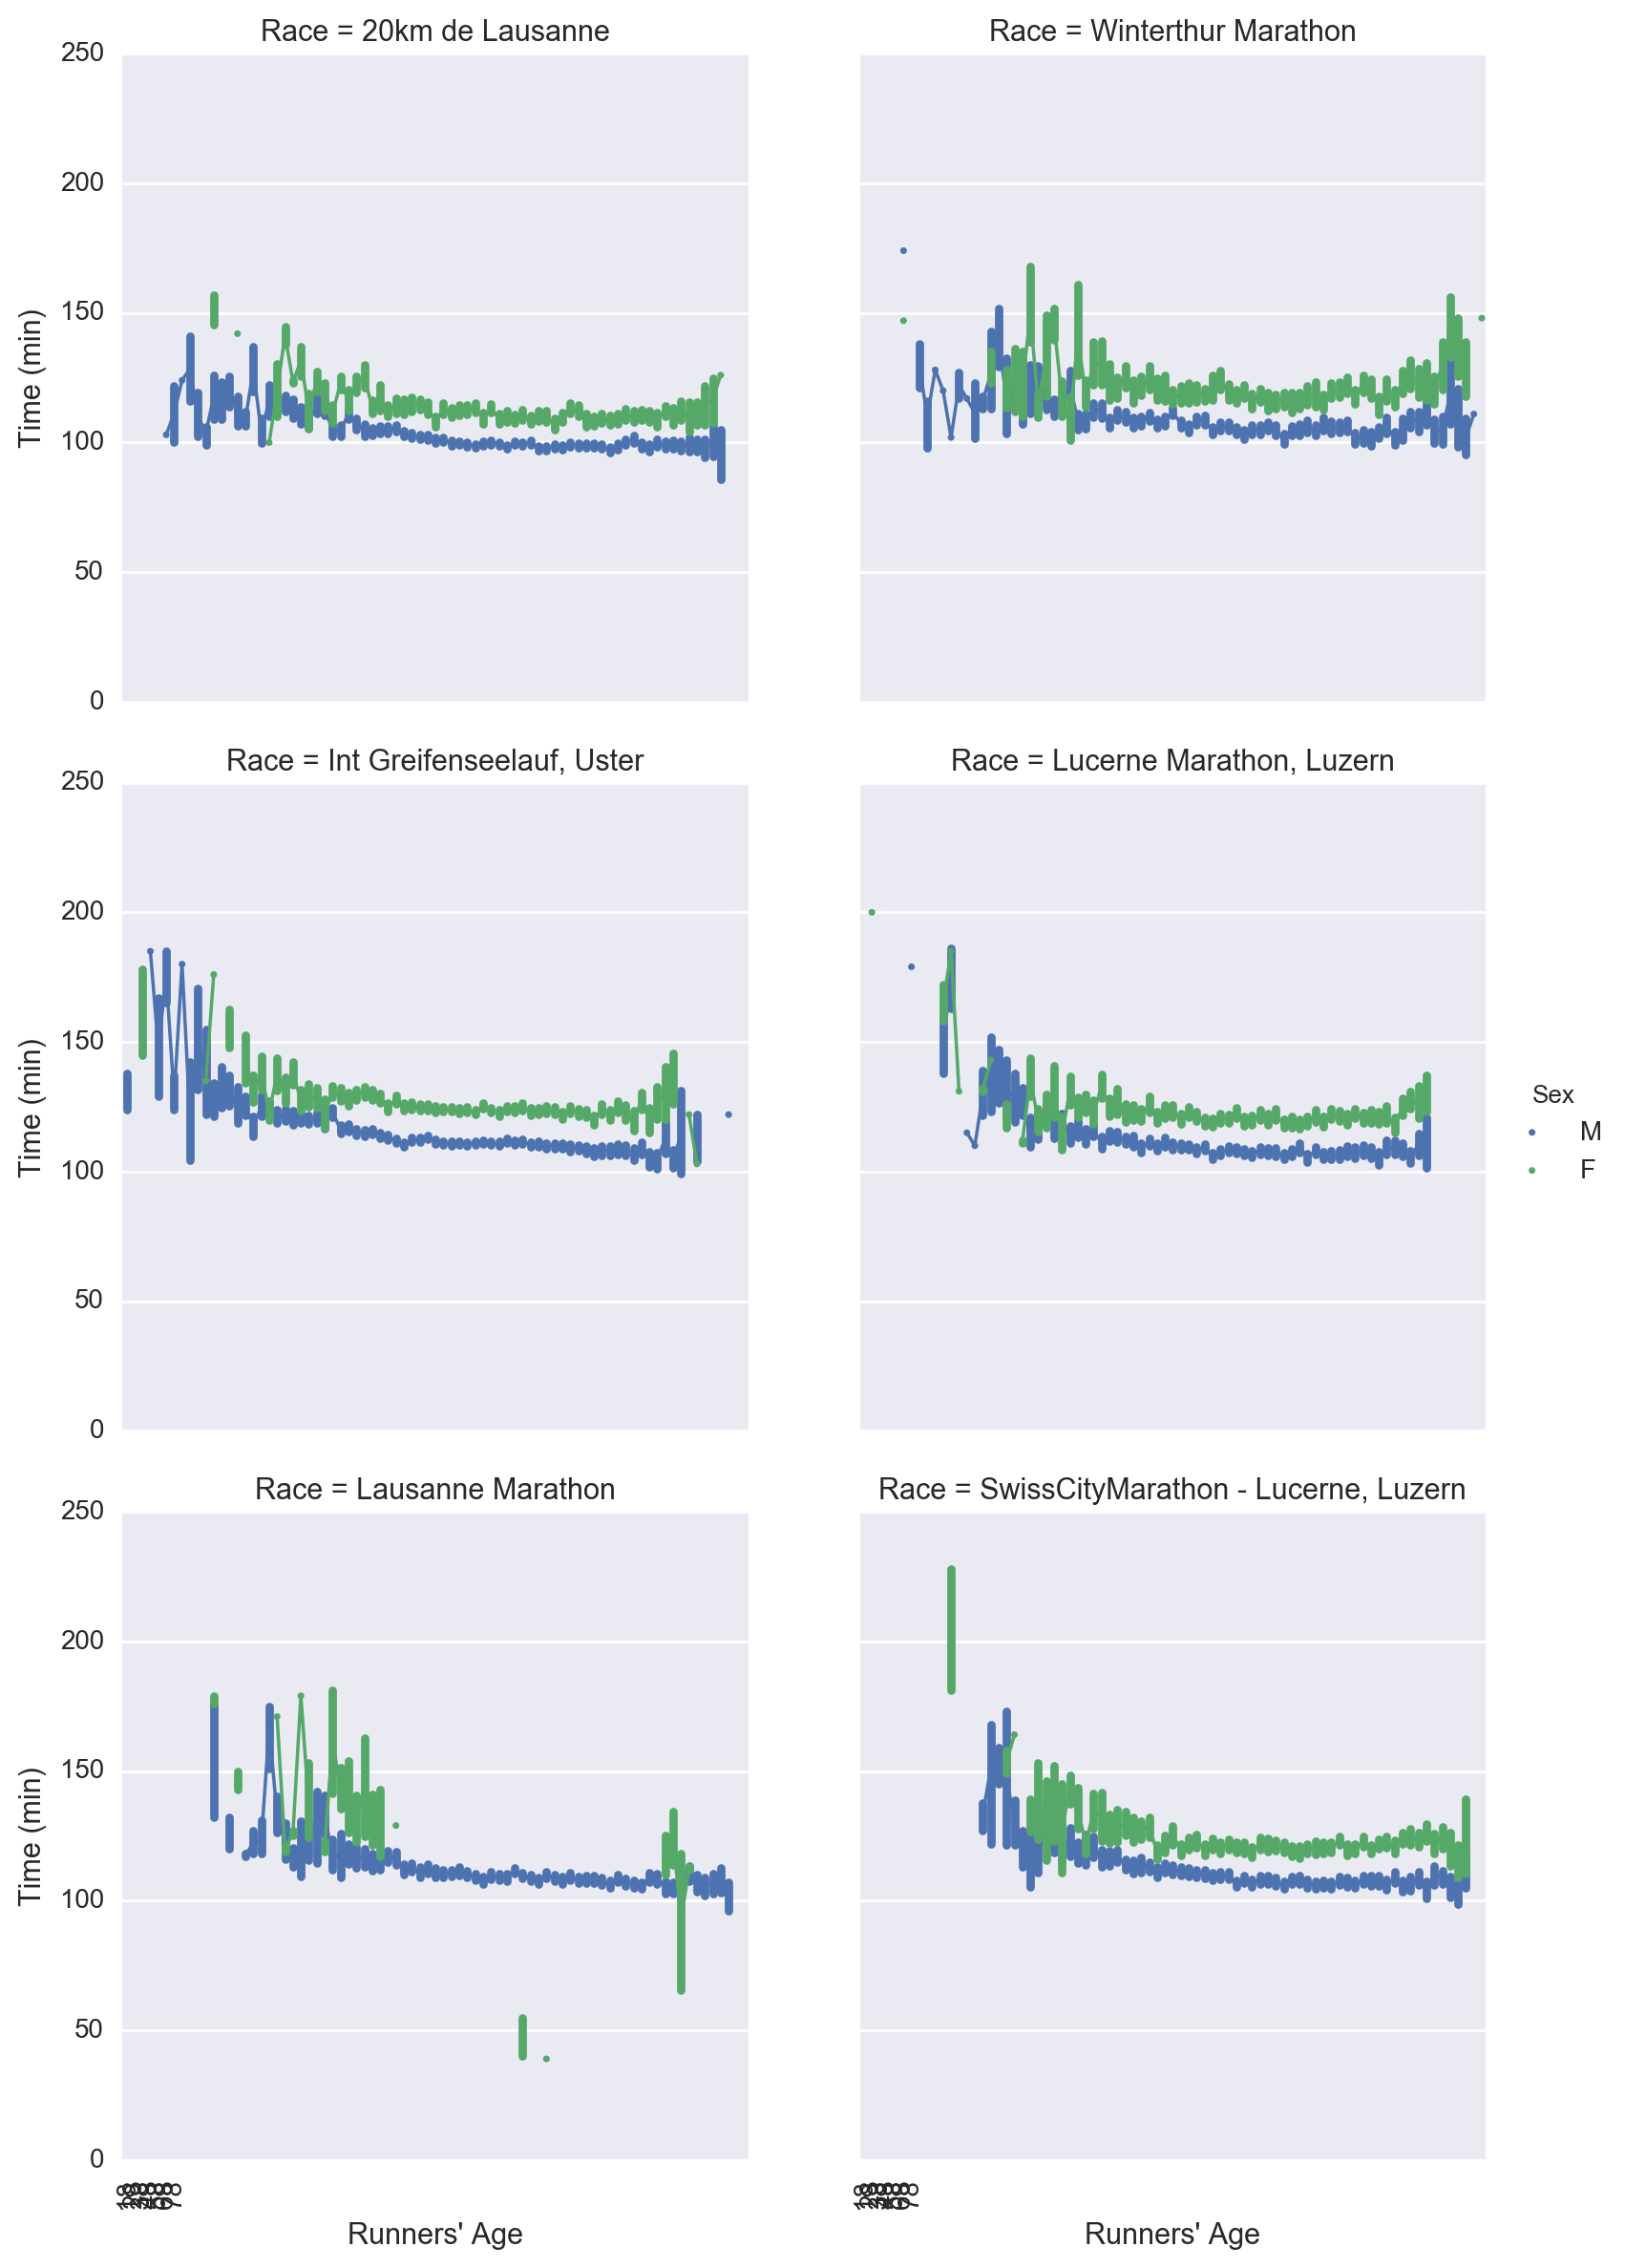

In [165]:
g = sns.factorplot(data=copy_for_U[copy_for_U.Distance.isin([20,21])],
                   x='Year',y='Time',
                   hue='Sex',col='Race',
                   scale=0.4,markers='.',
                   col_wrap=2);

g.set_xticklabels(np.arange(18,85,10),rotation=90)
g.set_ylabels('Time (min)');
g.set_xlabels('Runners\' Age');

#### Plot   data for  10 Km 

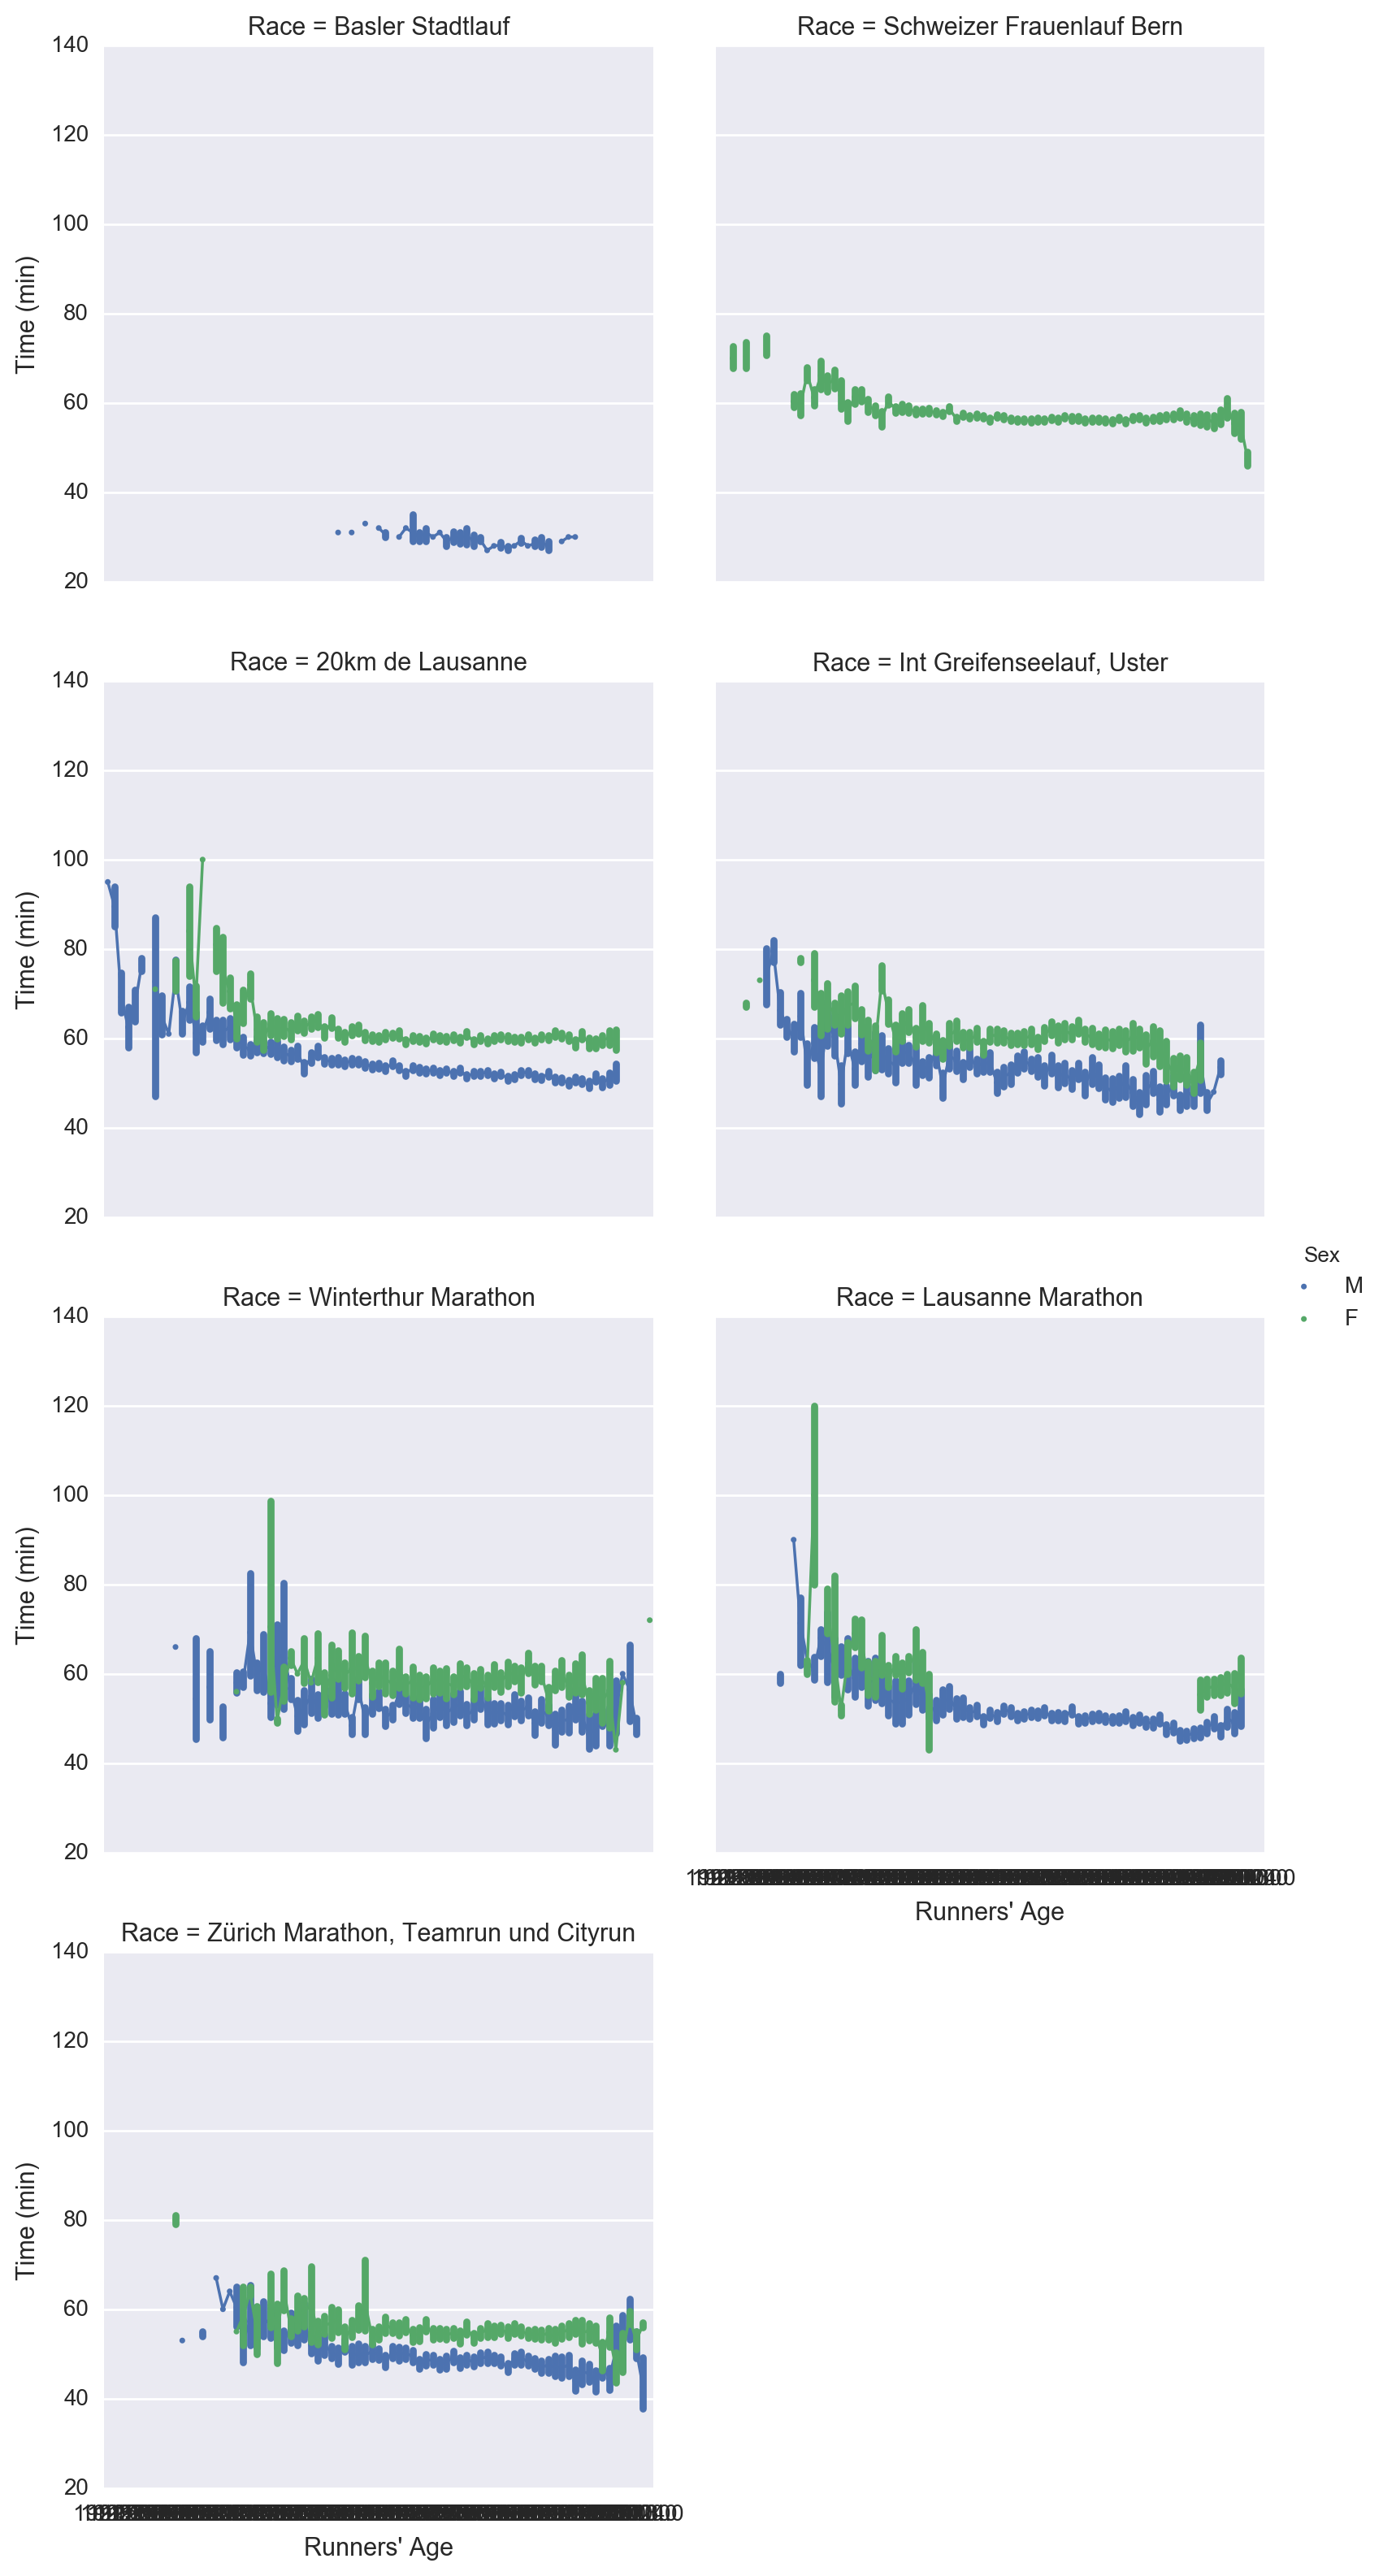

In [170]:
g = sns.factorplot(data=copy_for_U[copy_for_U.Distance == 10],
                   x='Year',y='Time',
                   hue='Sex',col='Race',
                   scale=0.4,markers='.',
                   col_wrap=2);


# g.set_xticklabels(np.arange(18,85,10),rotation=90)
g.set_ylabels('Time (min)');
g.set_xlabels('Runners\' Age');

#### Conclusions:

On the one hand, the U-dependence observerd in the literature, _is present_ for the most popular swiss events.  
On the other hand, it _becomes more visible with longer distances_ (full marathon), while  'fading out' for shorter distance, like 20 and 10 km.

Remove useless copy to save RAM 

In [12]:
del copy_for_U

### Performance VS Weather

One of the main study on this topic, from 
[2007](http://journals.lww.com/acsm-msse/pages/articleviewer.aspx?year=2007&issue=03000&article=00012&type=abstract), found correlation between 
[WBGT](https://en.wikipedia.org/wiki/Wet-bulb_globe_temperature)
and decrease of performance, both for male and female runners - 
we don't have WBGT data, but we could try to compute it following this 
[paper](https://pdfs.semanticscholar.org/c43f/78bf1cc042130280f8aaa6b6725c1df49c75.pdf) or this
[website](http://www.climatechip.org/heat-stress-index-calculation).       
(An older study from 
[1997](http://journals.lww.com/acsm-msse/pages/articleviewer.aspx?year=1997&issue=09000&article=00018&type=abstract)
found similar negative effects of high ambient temperature on resistance in cyclists)

#### Check correlation between Min and Max T 

In [70]:
# we group by the relevant race, or order to investigate significant changes in 
# NOTE THAT temperatures are the same for all runners in each (competion,year), so taking the mean() is equivalent to the unique

grouped_copy_W =  copy_for_W.groupby(['Race','RaceYear','Sex'])[['MinTemp','MaxTemp','Time']].mean()
grouped_copy_W.head()

MinTemp  MaxTemp       Time
Race             RaceYear Sex                             
20km de Lausanne 2009     F        6.0     18.0  62.645718
                          M        6.0     18.0  54.512245
                 2010     F        8.0     19.0  72.316880
                          M        8.0     19.0  65.700977
                 2011     F        7.0     18.0  71.492675

/Users/lazzari/anaconda/envs/py3k/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


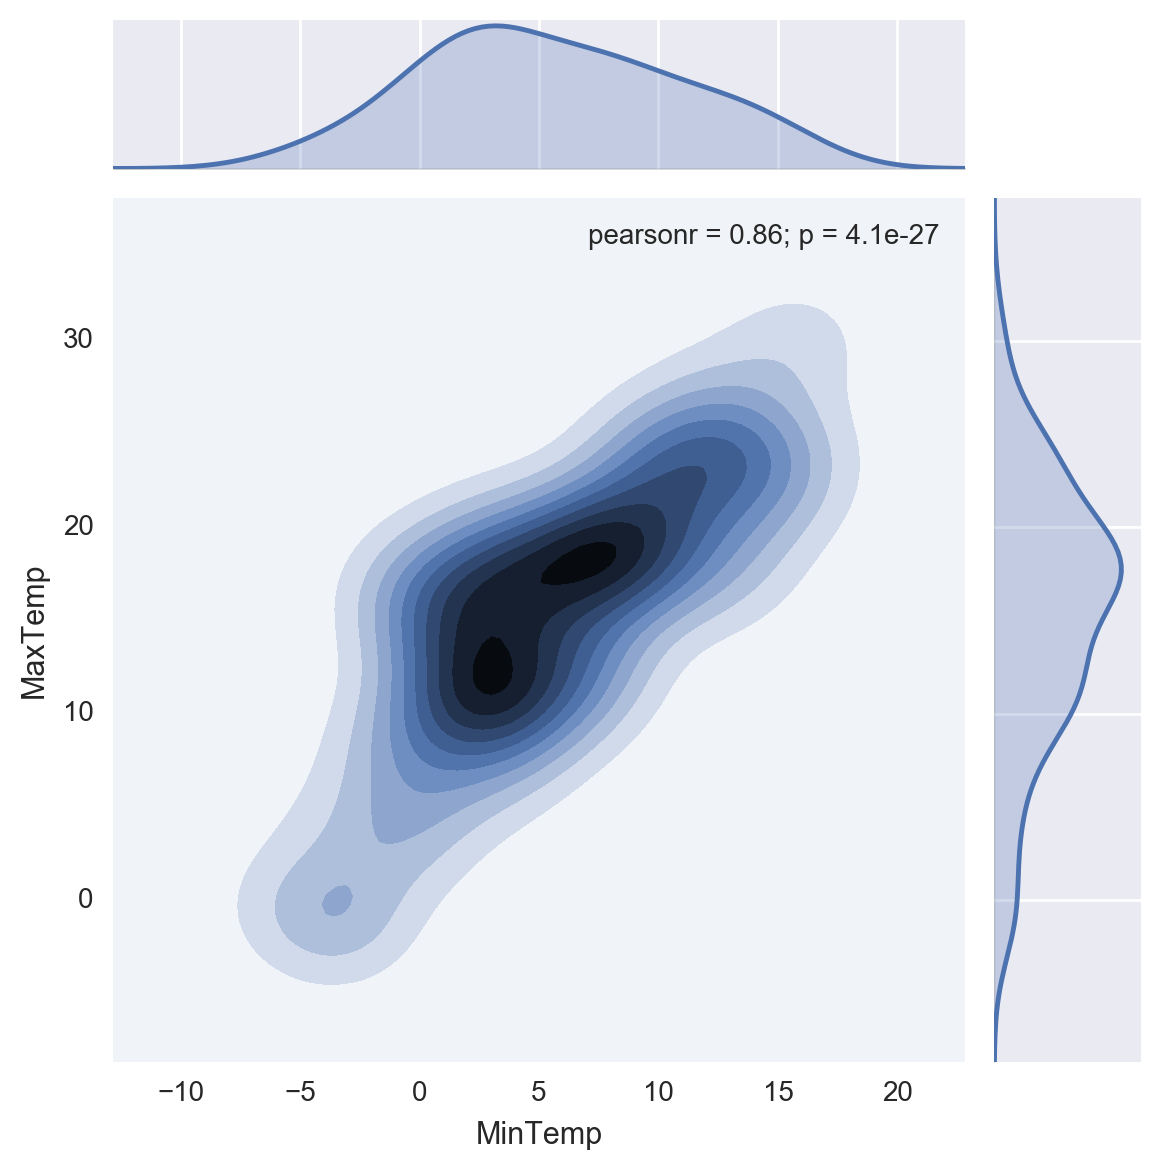

In [67]:
sns.jointplot(grouped_copy_W.MinTemp,grouped_copy_W.MaxTemp,kind='kde');

As they are well correlated, _as expected_, we will consider _only the Max temperature_, to study  the correlation with performance

#### Plot Time VS Temperature for marathons

We first consider the _most popular marathons_ - mind that there are not so many runner, in 4 marathons considered:

In [23]:
print('original dataset size:',full_df.shape)
print('dataset size after subsetting for 42 km:',full_df[many_runners_races & (full_df.Distance==42)].shape)

original dataset size: (1648676, 16)
dataset size after subsetting for 42 km: (73666, 16)


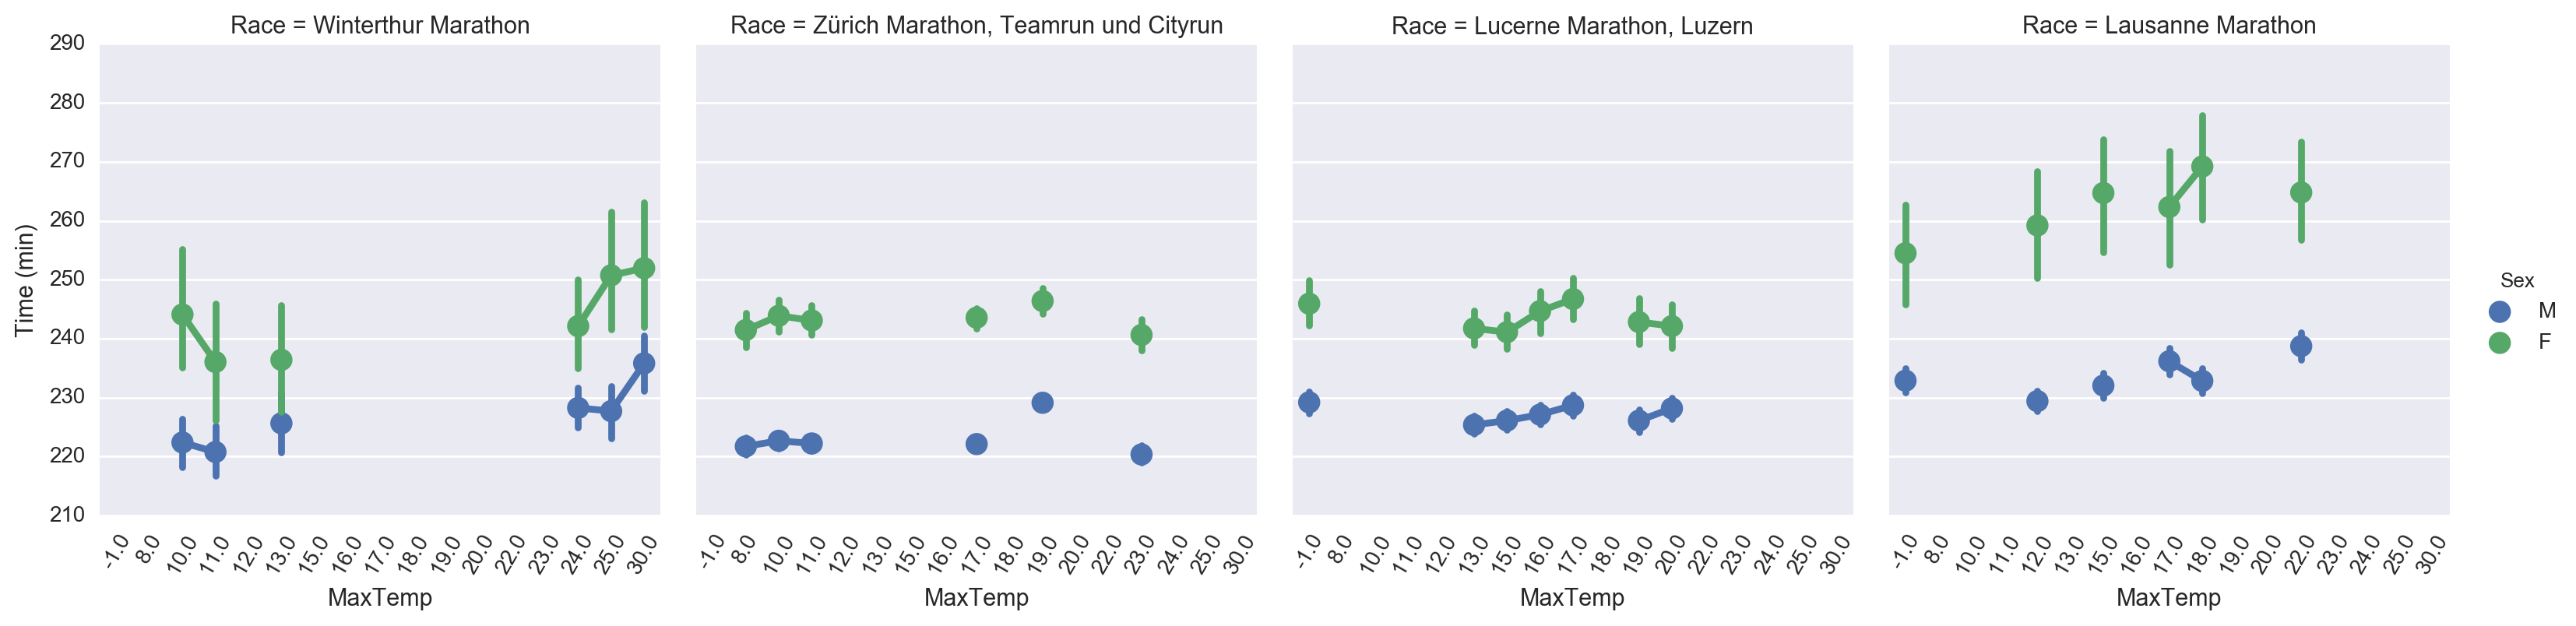

In [13]:
g = sns.factorplot(data=full_df[many_runners_races & (full_df.Distance==42)],
                   x='MaxTemp',y='Time',
               col='Race',hue='Sex')

g.set_ylabels('Time (min)');
g.set_xticklabels(rotation=60);

#### Plot Time VS Temperature for 21 Km

In [27]:
print('original dataset size:',full_df.shape)
print('dataset size after subsetting for 21 km:',full_df[many_runners_races & (full_df.Distance==21)].shape)

original dataset size: (1648676, 16)
dataset size after subsetting for 21 km: (130091, 16)


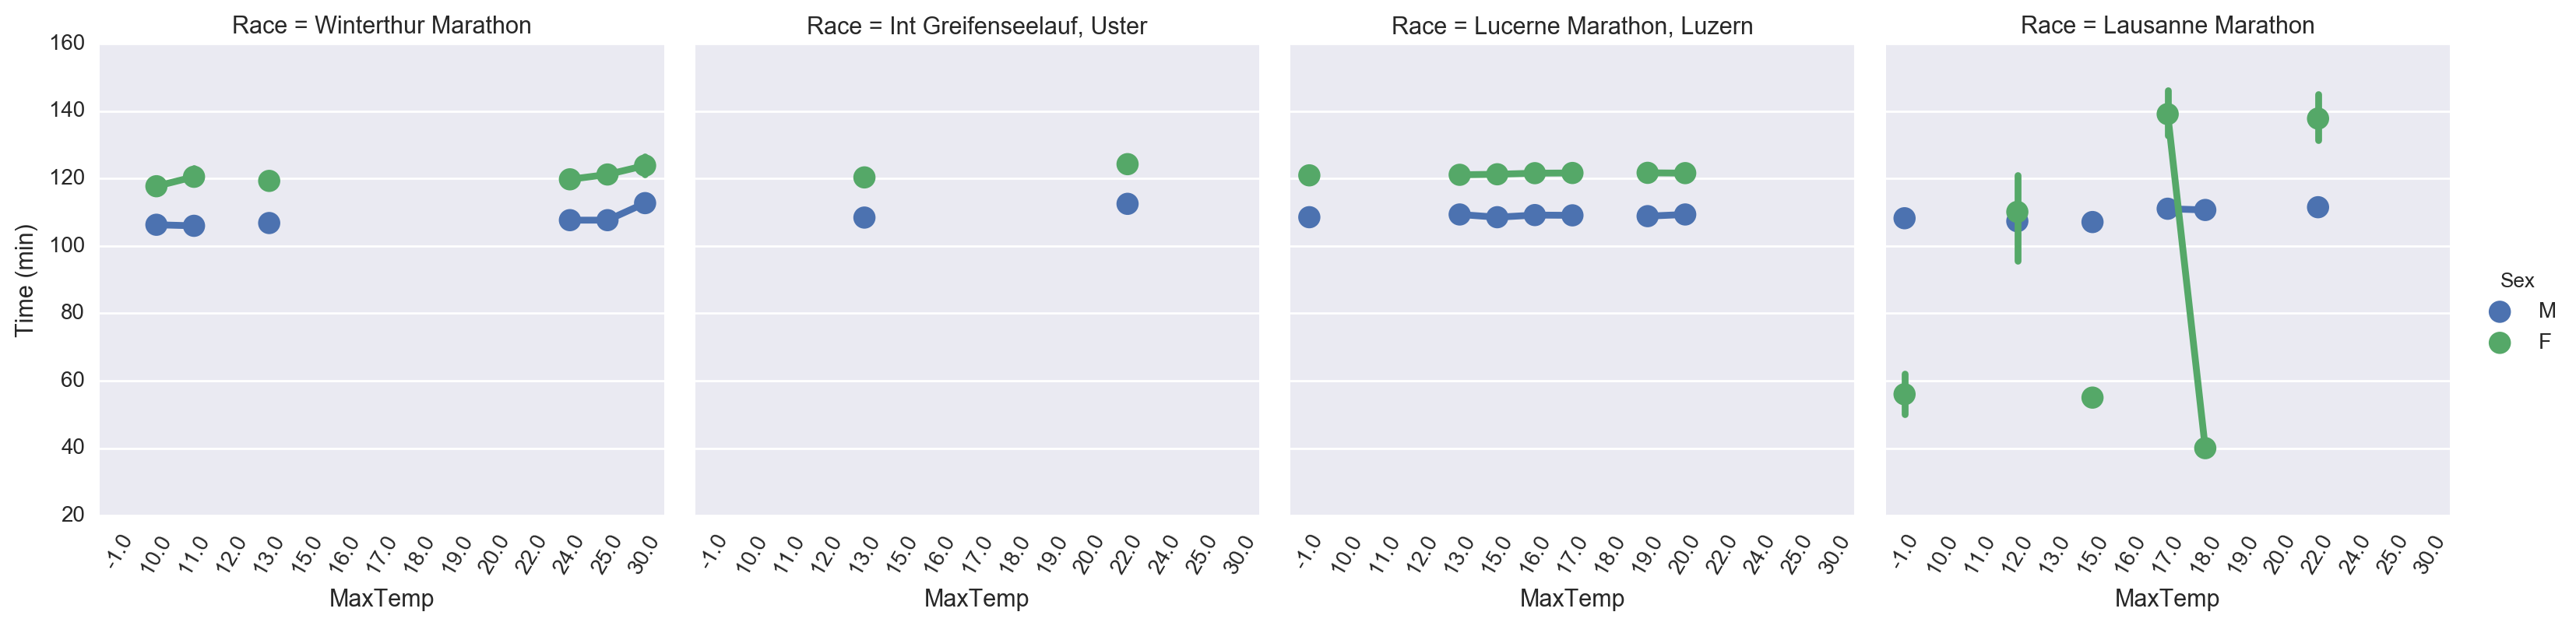

In [26]:
g = sns.factorplot(data=full_df[many_runners_races & (full_df.Distance==21)],
                   x='MaxTemp',y='Time',
               col='Race',hue='Sex')

g.set_ylabels('Time (min)');
g.set_xticklabels(rotation=60);

#### Plot Time VS Temperature for 10 Km

In [25]:
print('original dataset size:',full_df.shape)
print('dataset size after subsetting for 10 km:',full_df[many_runners_races & (full_df.Distance==10)].shape)

original dataset size: (1648676, 16)
dataset size after subsetting for 10 km: (118205, 16)


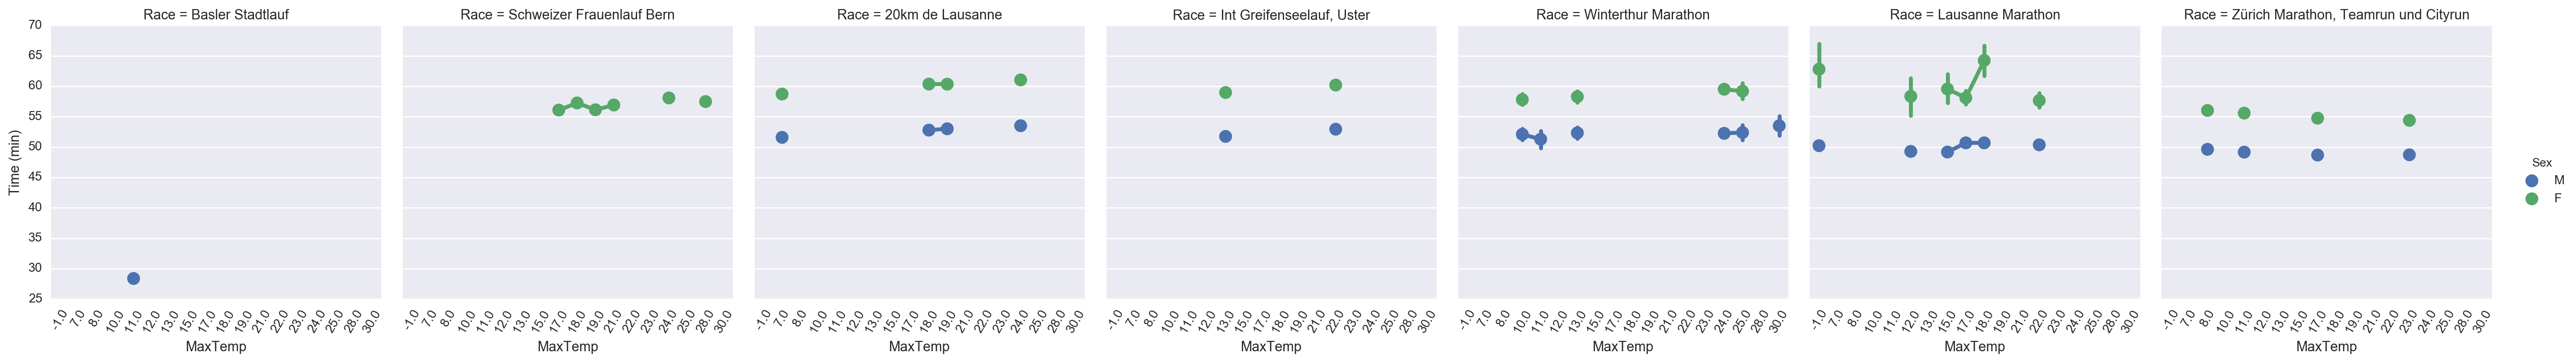

In [22]:
g = sns.factorplot(data=full_df[many_runners_races & (full_df.Distance==10)],
                   x='MaxTemp',y='Time',
               col='Race',hue='Sex')

g.set_ylabels('Time (min)');
g.set_xticklabels(rotation=60);

#### Comment:   

* Instead of considering the races with largest number of runners, it seems more reasonable to consider the races with _largest number of editions_, as _different editions have probably different temperatures_

* Given that many races do not have standard distances (10, 20, 42 Km), we will consider _Pace, instead of Time_

#### Plot Pace VS Temperature

In [8]:
name_race_edi_count = [r[0] for r in sorted_race_edi_count]

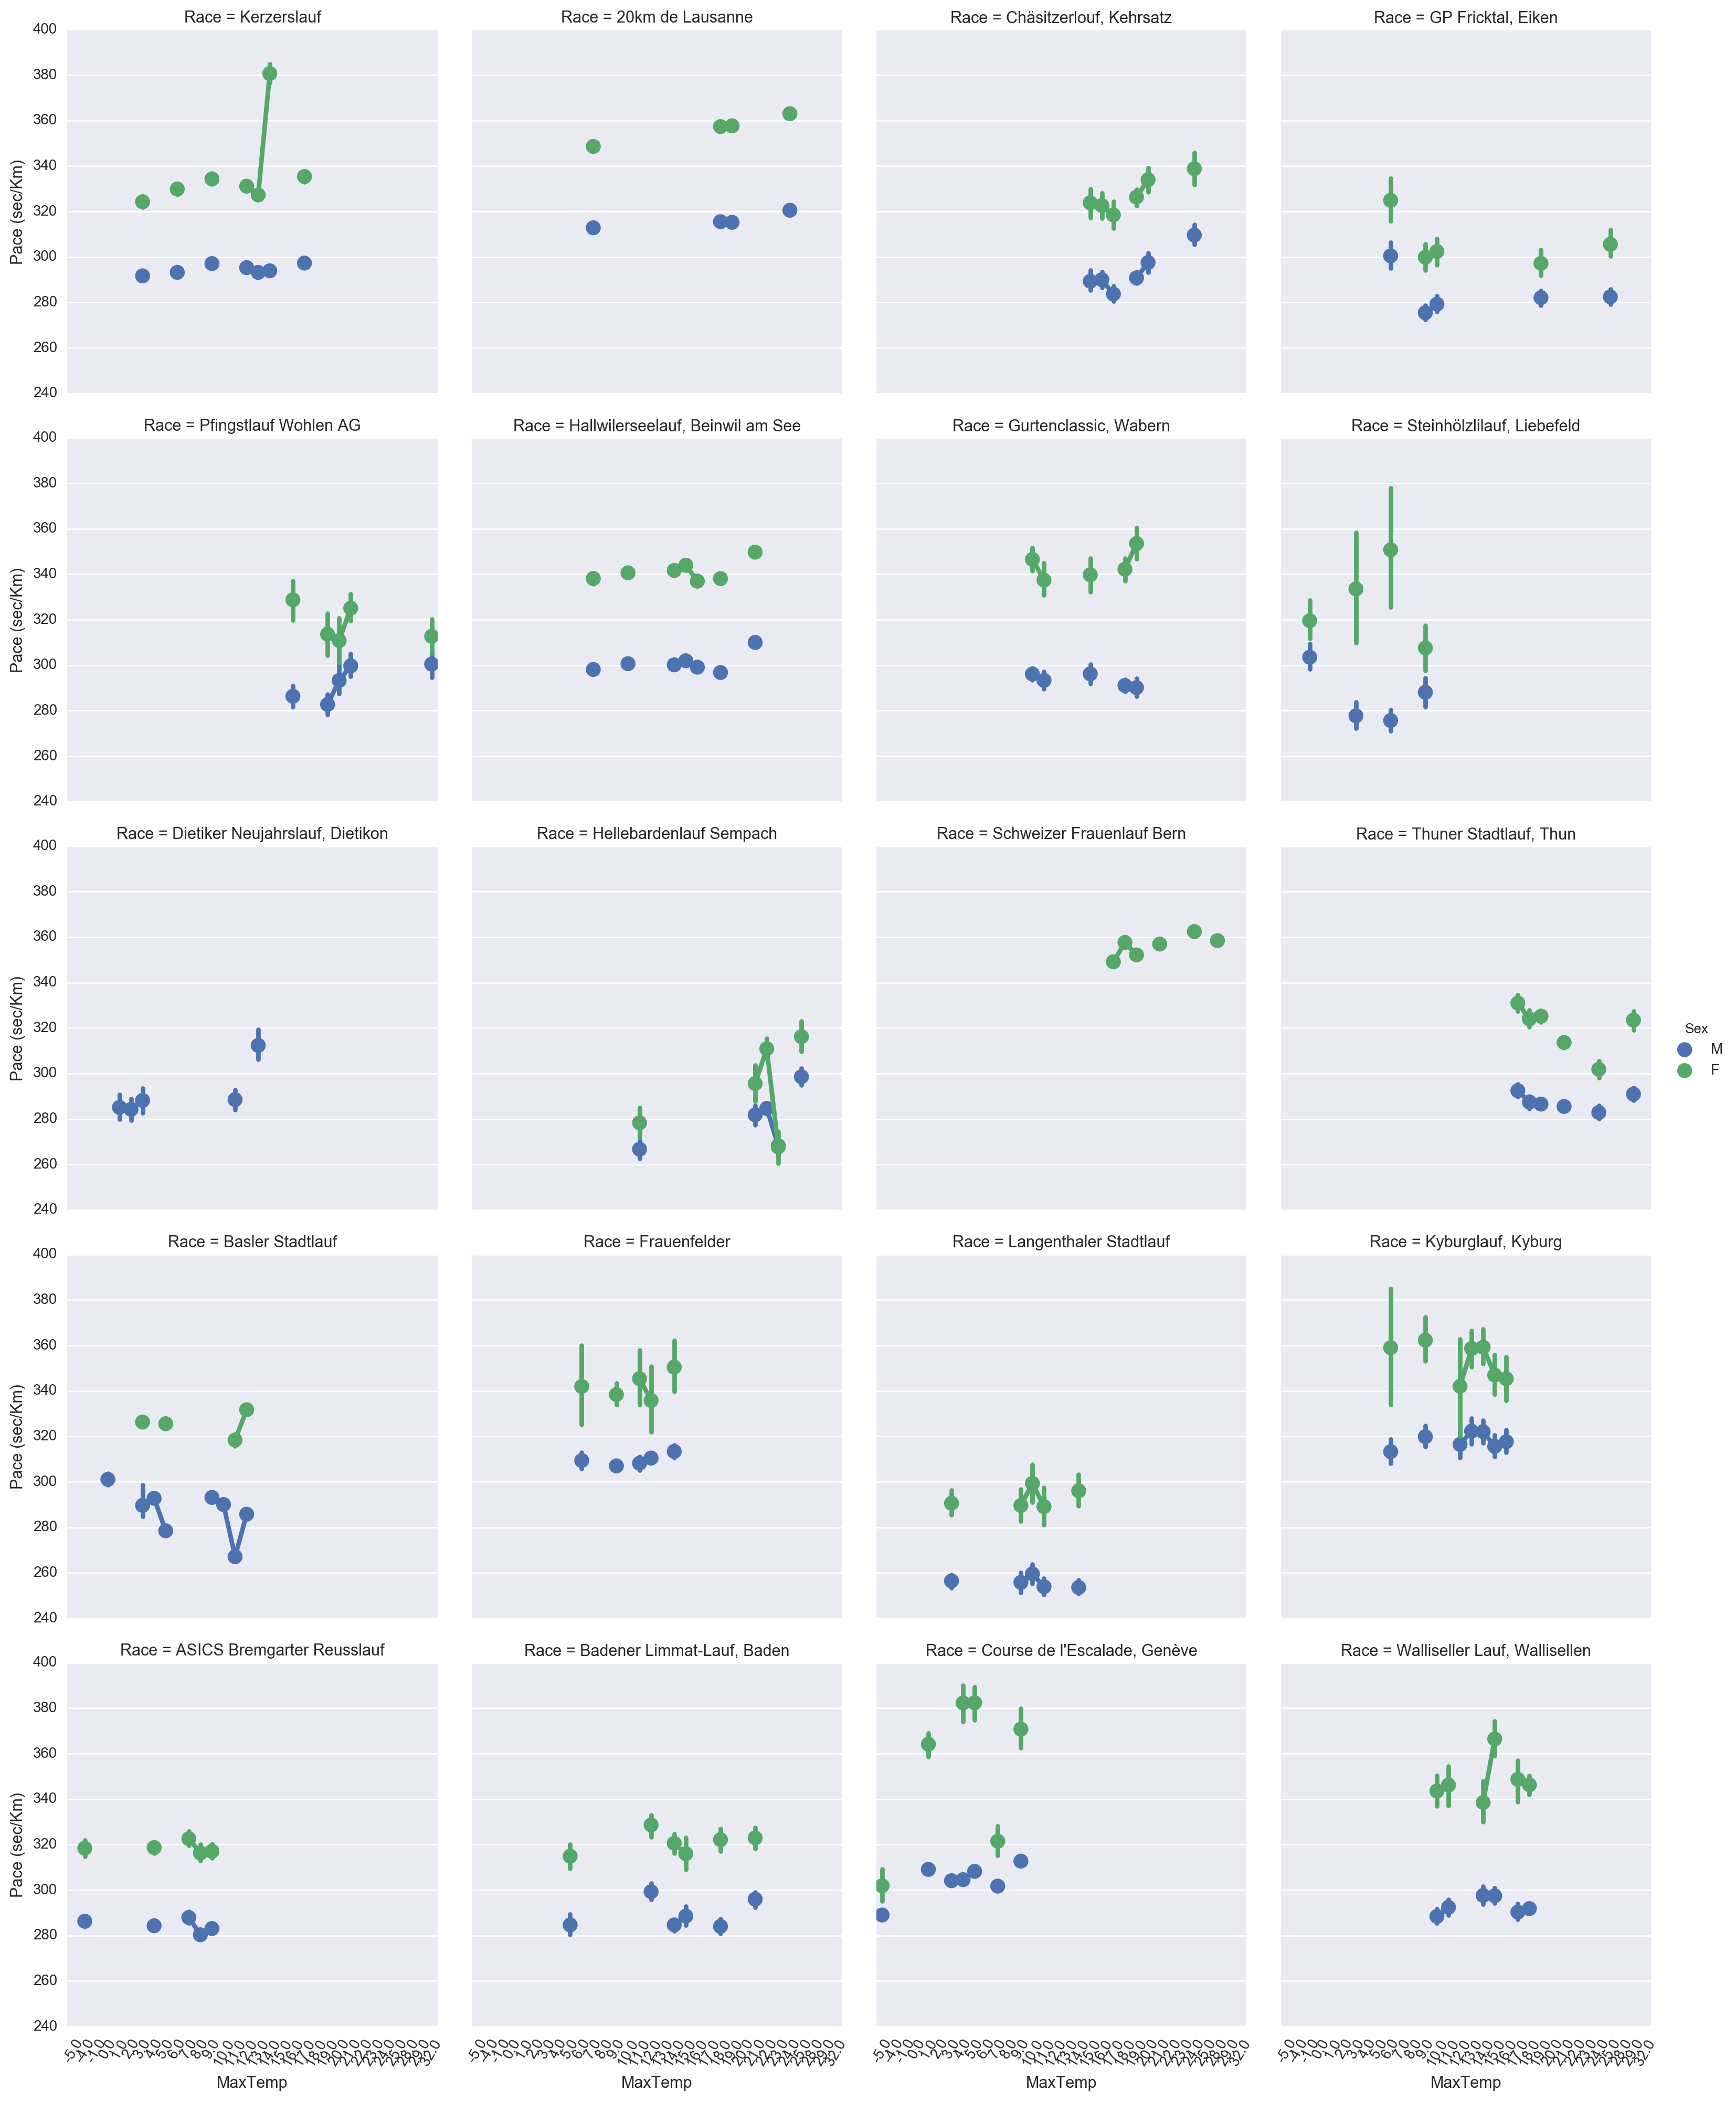

In [9]:
g = sns.factorplot(data=full_df[full_df.Race.isin(name_race_edi_count)],
                   x='MaxTemp',y='Pace',
               col='Race',hue='Sex',col_wrap=4)

g.set_ylabels('Pace (sec/Km)');
g.set_xticklabels(rotation=60);

## Predictive Statistics

### Prediction of athletes' career progression

This article on 
[fivethirtyeight](http://fivethirtyeight.com/features/tell-us-two-things-and-well-tell-you-how-fast-youd-run-a-marathon/) 
summarises the results of a recent 
[study](https://bmcsportsscimedrehabil.biomedcentral.com/articles/10.1186/s13102-016-0052-y).
The authors improved a long-standing prective model from 
[1981](http://www.runscore.com/coursemeasurement/Articles/ARHE.pdf),
that estimates the performance (min) of an athlete on the next race, based the distance and performance on the previous one.

# ------   OLD CODE ------

In [6]:
# num_runners = 0

# for name in  full_df.Name.unique():
            
#     num_runners += full_df[full_df.Name==name].Year.nunique()